In [1]:
import pandas as pd
from metasense.data import load_board
from path import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [2]:
DATA_DIR = Path("/home/sharad/data/metasense/la/")

In [3]:
(X_train, Y_train), (X_test, Y_test) = load_board(4)

## Sanity Check

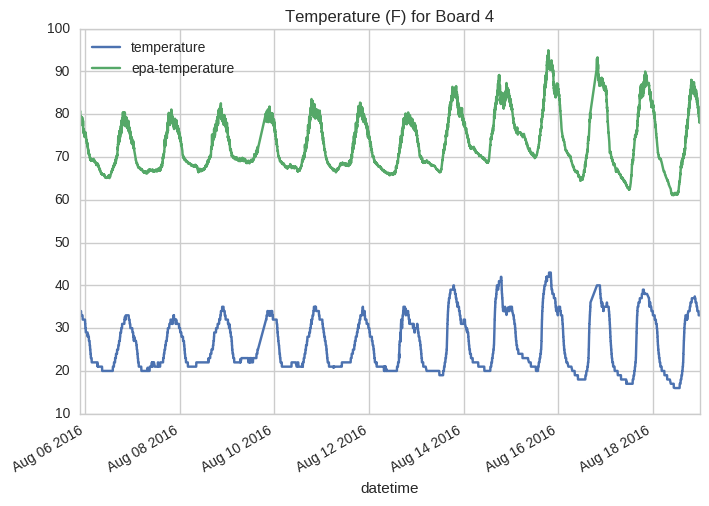

In [4]:
X_train[['temperature', 'epa-temperature']].plot()
plt.title("Temperature (F) for Board 4")
plt.show()

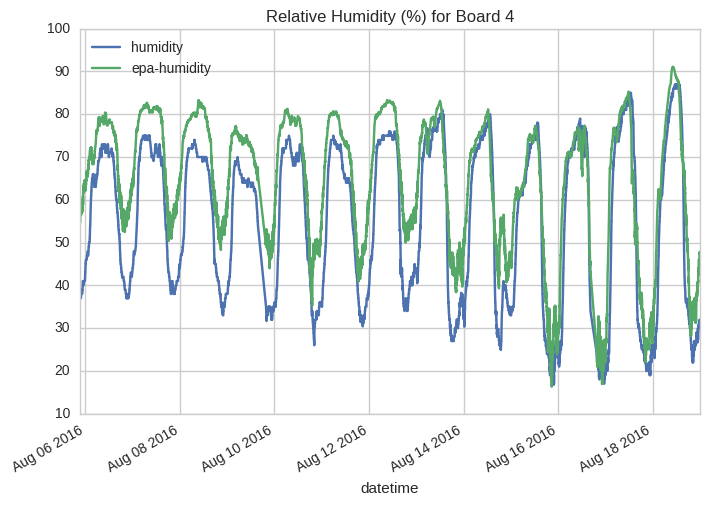

In [5]:
X_train[['humidity', 'epa-humidity']].plot()
plt.title("Relative Humidity (%) for Board 4")
plt.show()

# Training with board 4

Let's see how models perform. We'll train on the first two weeks and evaluate on the rest of the data.

In [28]:
train_data, test_data = X_train.join(Y_train), X_test.join(Y_test)
def benchmark(name, cf, features, output):
    cf.fit(train_data[features], train_data[output])
    error = (test_data[output] - cf.predict(test_data[features])) ** 2
    print("%s: %f" % (name, np.sqrt(error.mean())))
    return (name, error, cf, features)

BENCHMARKS = [
    ("Linear[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', LinearRegression())])),
    ("Linear[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', LinearRegression())])),
    ("Ridge[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', Ridge(5))])),
    ("Ridge[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', Ridge(5))])),
    ("Lasso[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', Lasso(5))])),
    ("Lasso[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', Lasso(5))])),
]
CO_FEATURES = (["co", "temperature", "humidity", "pressure"], "epa-co")
O3_FEATURES = (["o3", "co", "temperature", "humidity", "pressure"], "epa-o3")
NO2_FEATURES = (["o3", "no2", "co", "temperature", "humidity", "pressure"], "epa-no2")
def benchmark_full(features, output):
    results = {}
    best = (float('inf'), None, None)
    for name, cf in BENCHMARKS:
        results[name] = benchmark(name, cf, features, output)
        _, error, _, _ = results[name]
        avg_error = np.sqrt(error.mean())
        if avg_error < best[0]:
            best = (avg_error, results[name], name)
    print("Best:", best[2])
    print_function(best[1])
    return best[:2]
def plot_dates(pred, actual, dates):
    plt.figure()
    test_data.loc[dates][pred].plot(alpha=0.8, legend=True)
    test_data.loc[dates][actual].plot(alpha=0.8, legend=True)
    test_data.loc[dates]['temperature'].plot(secondary_y=True, alpha=0.5, legend=True)
def plot_prediction(pred, actual):
    plot_dates(pred, actual, slice(None,'09-01-2016'))
    plot_dates(pred, actual, slice('09-01-2016','09-15-2016'))
    plot_dates(pred, actual, slice('09-15-2016','10-01-2016'))
    plot_dates(pred, actual, slice('10-01-2016',None))
    plt.show()
def print_function(result):
    name, _, cf, features = result
    poly = cf.named_steps['poly']
    func = cf.named_steps['cf'].coef_
    intercept = cf.named_steps['cf'].intercept_
    print("f(x) = ", end="")
    terms = []
    for term in poly.powers_:
        polyterms = ["%s^%u" % (features[i], power) if power > 1 else "%s" % features[i] for i, power in enumerate(term) if power > 0]
        terms.append(" * ".join(polyterms))
    print(" + ".join(["%f * %s" % (c, t) for c, t in zip(func, terms) if c != 0.0] + [str(intercept)]))

Linear[1]: 0.128913
Linear[2]: 0.133629
Ridge[1]: 0.128913
Ridge[2]: 0.135865
Lasso[1]: 0.201290
Lasso[2]: 0.132570
Best: Linear[1]
f(x) = 0.003230 * co + -0.006324 * temperature + -0.001720 * humidity + -0.009923 * pressure + 10.3995054106


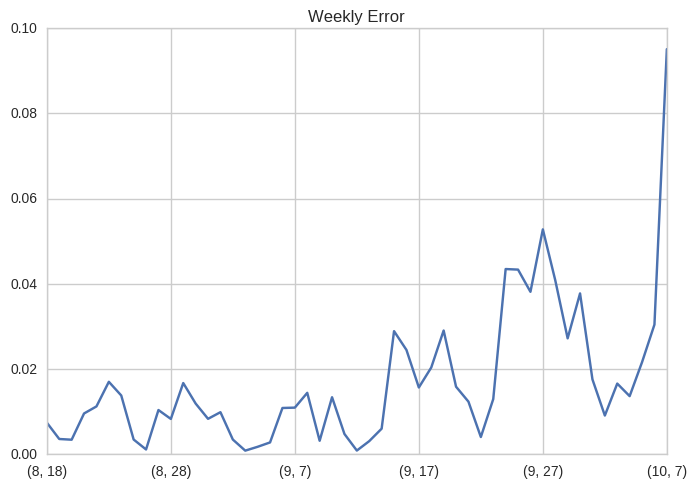

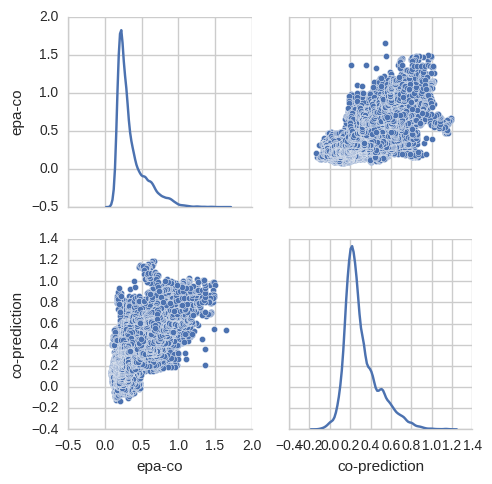

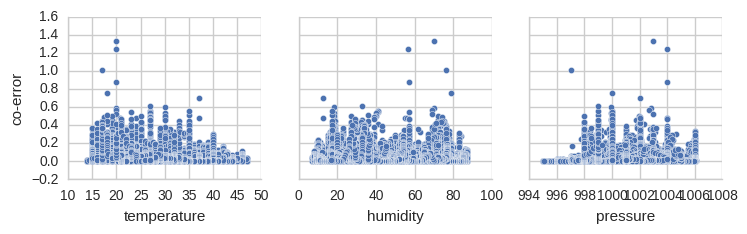

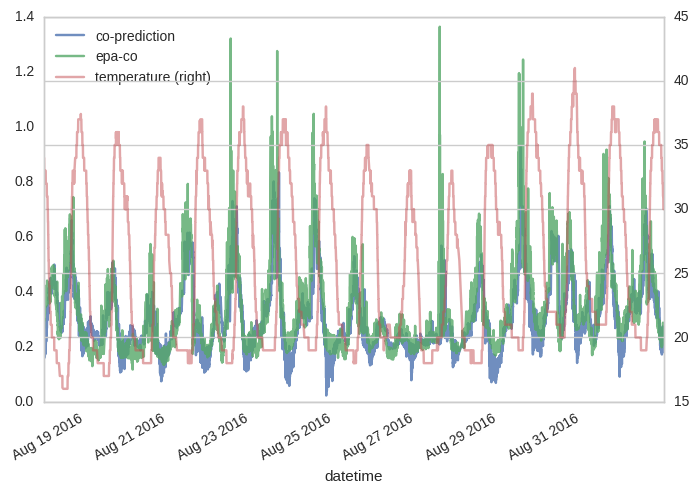

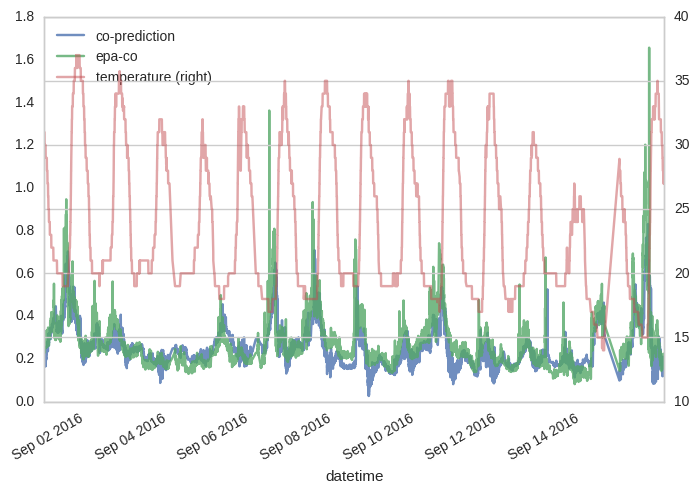

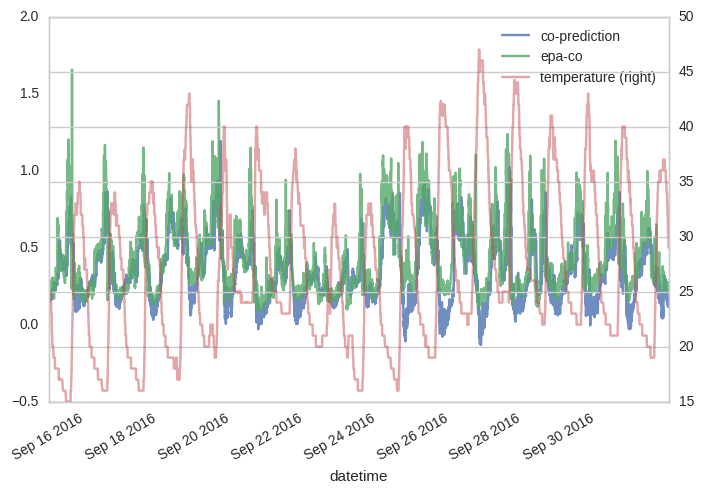

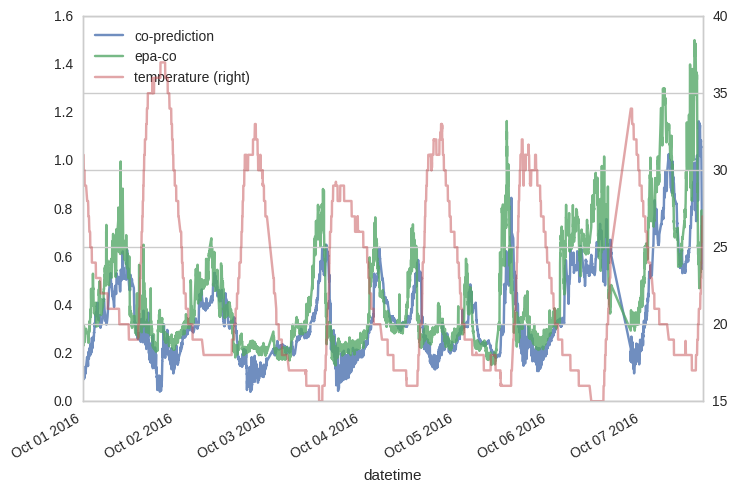

In [19]:
error, results = benchmark_full(*CO_FEATURES)
results[1].groupby(lambda x: (x.month, x.day)).mean().plot()
plt.title("Weekly Error")
test_data['co-error'] = results[1]
train_data['co-error'] = (results[2].predict(train_data[CO_FEATURES[0]]) - train_data[CO_FEATURES[1]])
test_data['co-prediction'] = results[2].predict(test_data[CO_FEATURES[0]])
train_data['co-prediction'] = results[2].predict(train_data[CO_FEATURES[0]])
sns.pairplot(test_data, vars=['epa-co','co-prediction'], diag_kind='kde')
sns.pairplot(test_data, y_vars=['co-error'], x_vars=['temperature', 'humidity', 'pressure'], diag_kind='kde')
plot_prediction('co-prediction', 'epa-co')
plt.show()

Linear[1]: 10.071693
Linear[2]: 16.955512
Ridge[1]: 10.071976
Ridge[2]: 14.375502
Lasso[1]: 12.670864
Lasso[2]: 13.033526
Best: Linear[1]
f(x) = 0.326110 * o3 + -0.140444 * co + 1.861654 * temperature + -0.063664 * humidity + 0.229203 * pressure + -273.033684486


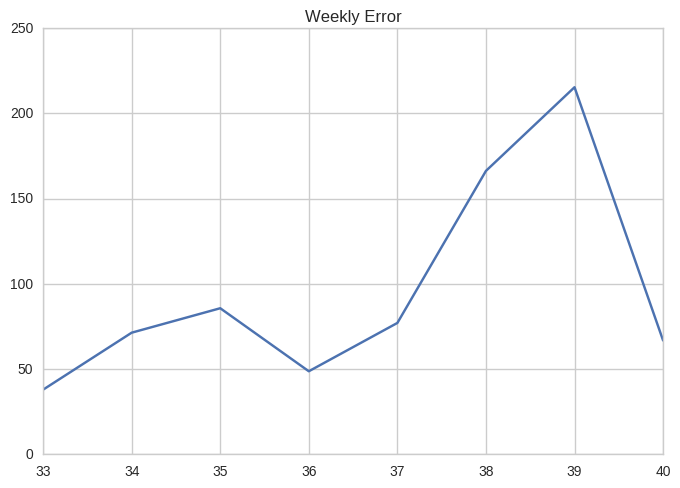

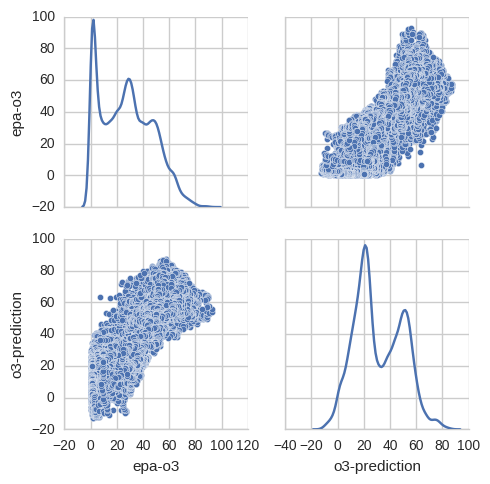

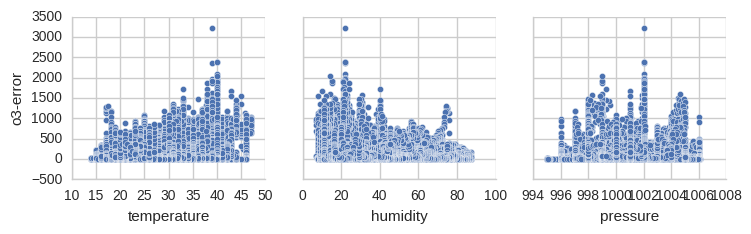

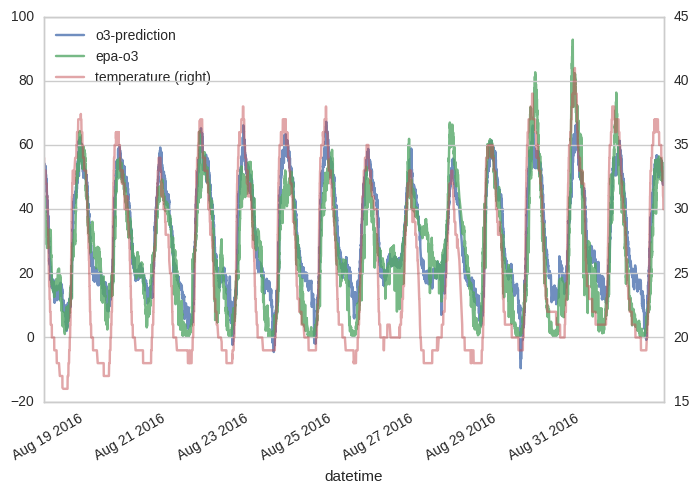

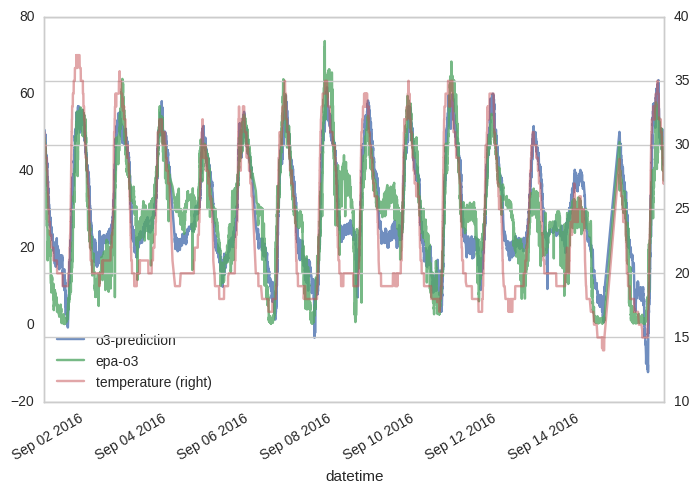

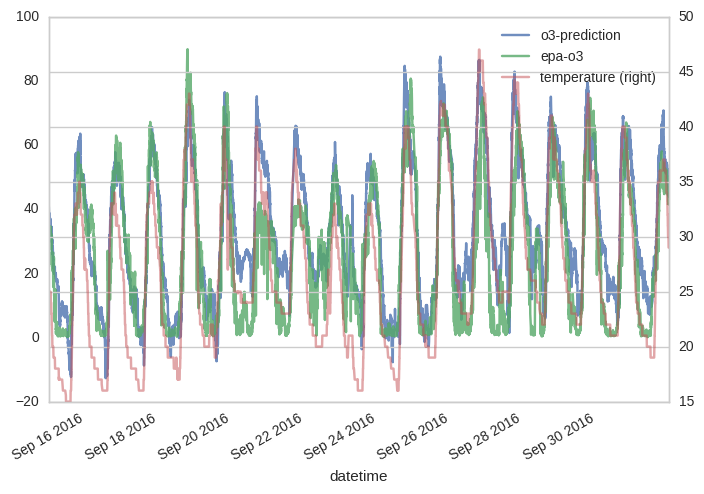

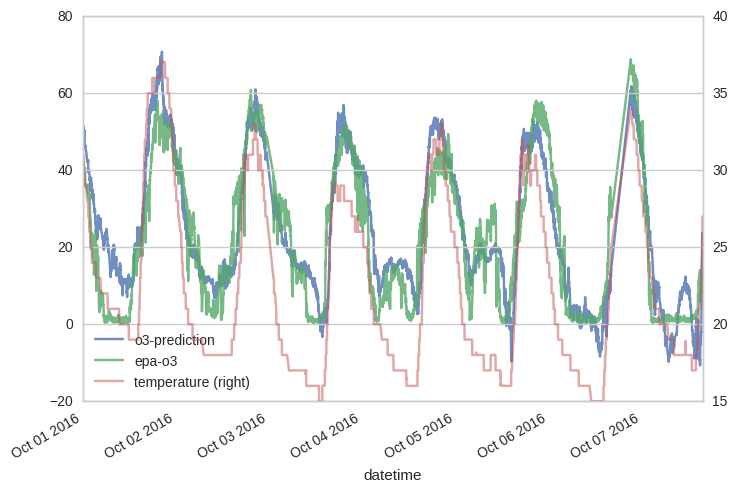

In [29]:
error, results = benchmark_full(*O3_FEATURES)
plt.figure()
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
test_data['o3-error'] = results[1]
train_data['o3-error'] = (results[2].predict(train_data[O3_FEATURES[0]]) - train_data[O3_FEATURES[1]])
test_data['o3-prediction'] = results[2].predict(test_data[O3_FEATURES[0]])
train_data['o3-prediction'] = results[2].predict(train_data[O3_FEATURES[0]])
sns.pairplot(test_data, vars=['epa-o3','o3-prediction'], diag_kind='kde')
sns.pairplot(test_data, y_vars=['o3-error'], x_vars=['temperature', 'humidity', 'pressure'], diag_kind='kde')
plot_prediction('o3-prediction', 'epa-o3')
plt.show()

# NO2 with corrections

Linear[1]: 6.719409
Linear[2]: 7.779242
Ridge[1]: 6.719369
Ridge[2]: 8.925157
Lasso[1]: 8.108391
Lasso[2]: 6.850286
Best: Ridge[1]
f(x) = -0.261196 * o3 + 0.199893 * no2 + 0.159473 * co + -0.191782 * temperature + -0.490720 * humidity + 0.250075 * pressure + -171.857375754


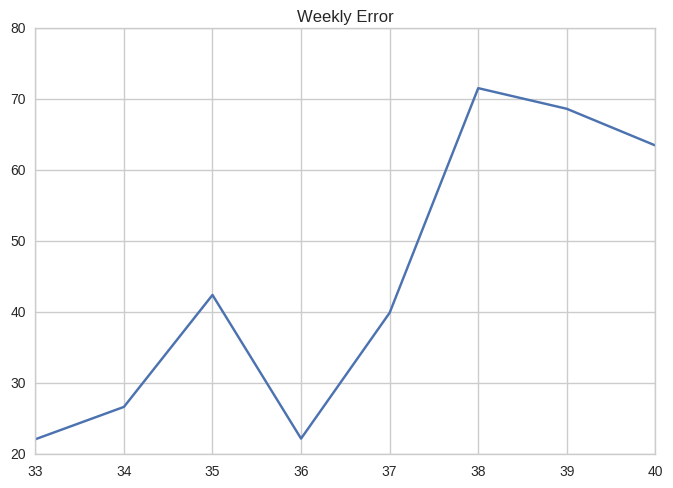

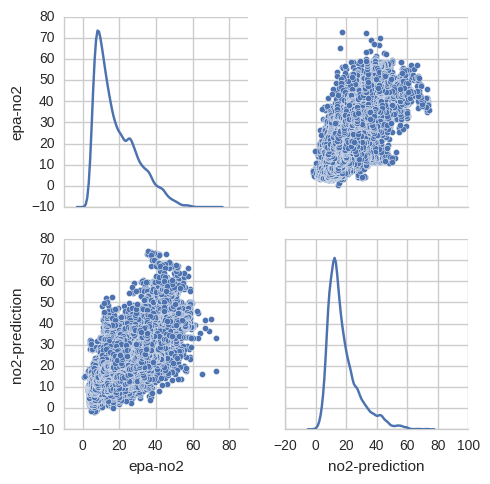

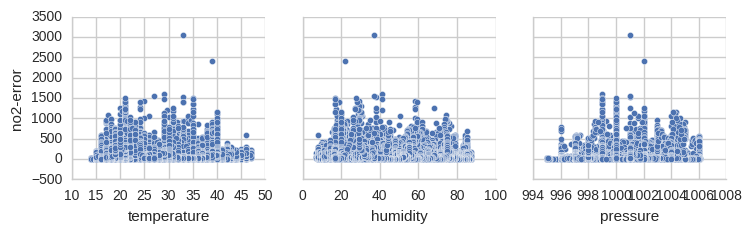

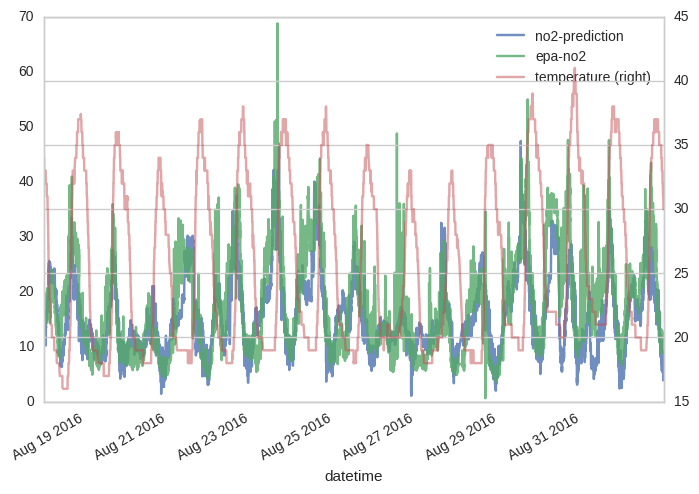

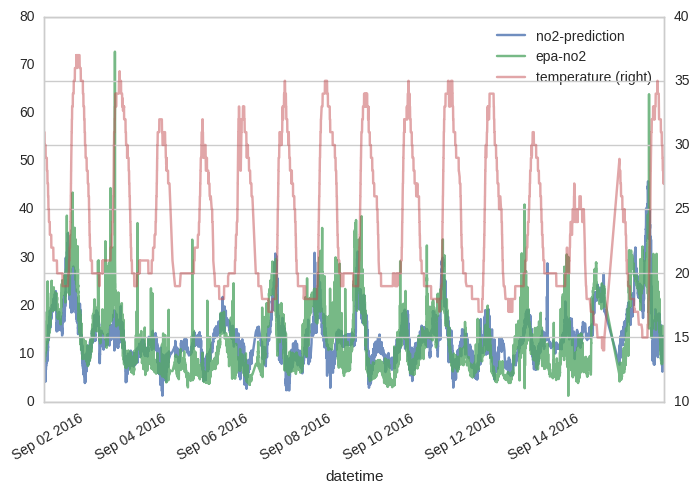

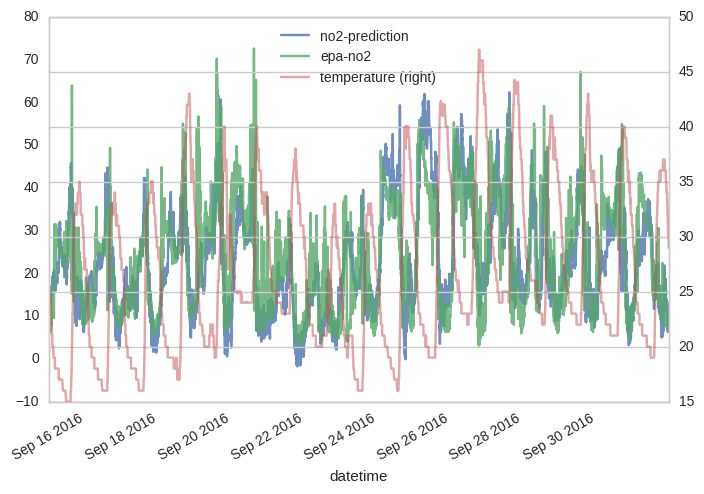

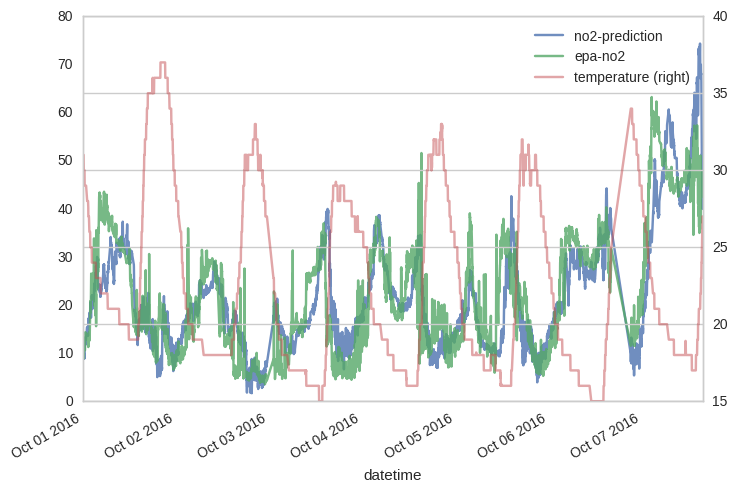

In [17]:
error, results = benchmark_full(*NO2_FEATURES)
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
test_data['no2-error'] = results[1]
train_data['no2-error'] = (results[2].predict(train_data[NO2_FEATURES[0]]) - train_data[NO2_FEATURES[1]])
test_data['no2-prediction'] = results[2].predict(test_data[NO2_FEATURES[0]])
train_data['no2-prediction'] = results[2].predict(train_data[NO2_FEATURES[0]])
sns.pairplot(test_data, vars=['epa-no2','no2-prediction'], diag_kind='kde')
sns.pairplot(test_data, y_vars=['no2-error'], x_vars=['temperature', 'humidity', 'pressure'], diag_kind='kde')
plot_prediction('no2-prediction', 'epa-no2')
plt.show()

# NO2 without corrections

Linear[1]: 6.761908
Linear[2]: 7.395185
Ridge[1]: 6.761971
Ridge[2]: 7.131615
Lasso[1]: 8.113662
Lasso[2]: 6.616295
Best: Lasso[2]
f(x) = 0.001927 * o3-u * co-u + 0.002158 * o3-u * temperature + -0.013832 * o3-u * humidity + 0.000007 * o3-u * pressure + -0.002285 * no2-u * co-u + 0.013872 * no2-u * humidity + -0.000088 * no2-u * pressure + -0.000271 * co-u^2 + 0.005718 * co-u * temperature + 0.000310 * co-u * humidity + 0.000043 * co-u * pressure + -0.001500 * temperature * pressure + 0.000964 * humidity^2 + -0.000190 * humidity * pressure + 0.000317 * pressure^2 + -266.918381915


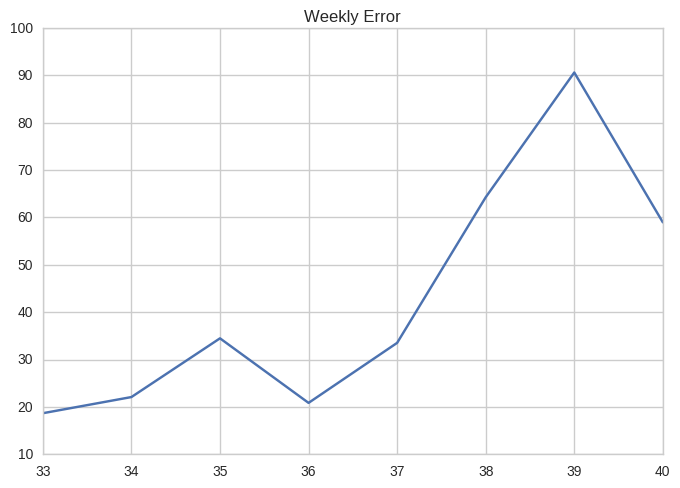

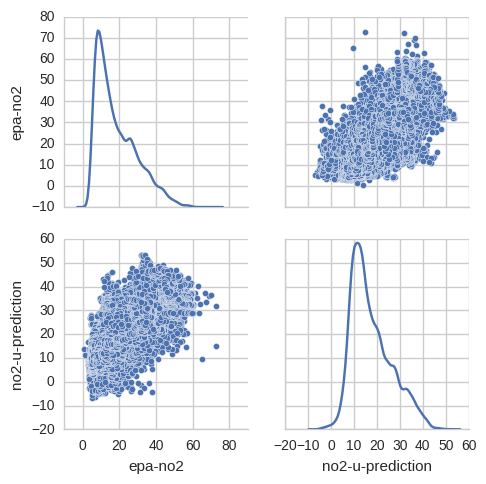

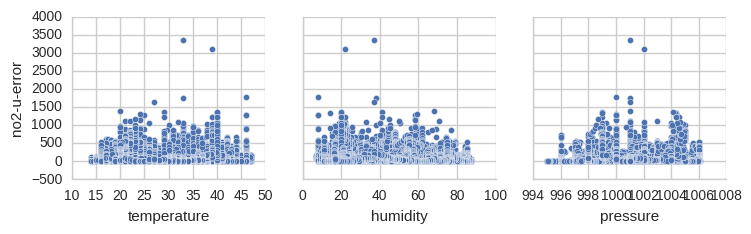

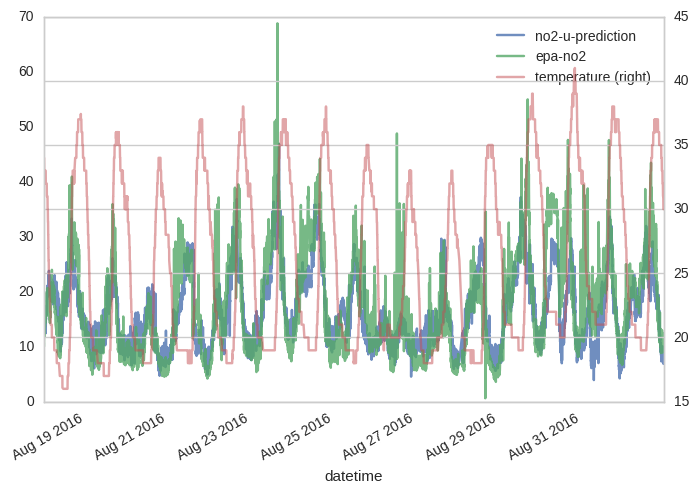

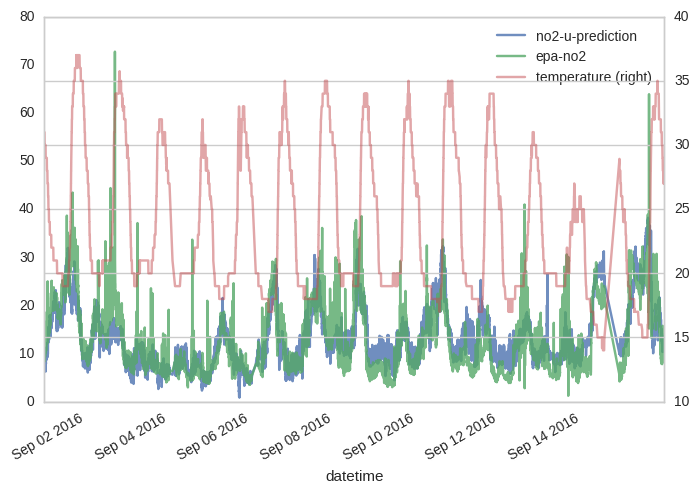

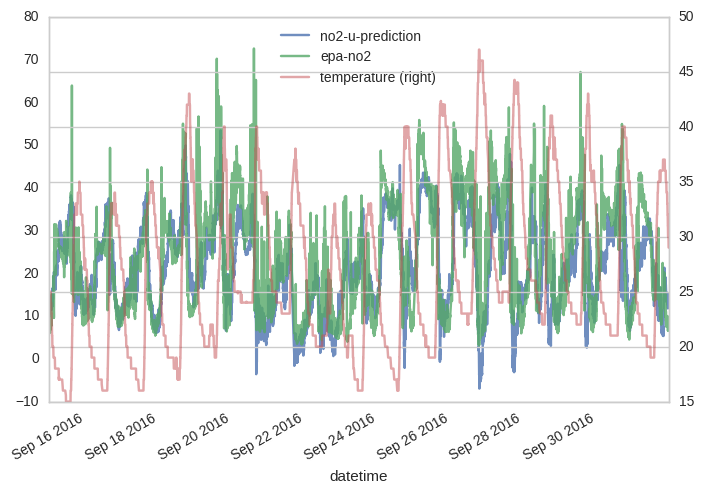

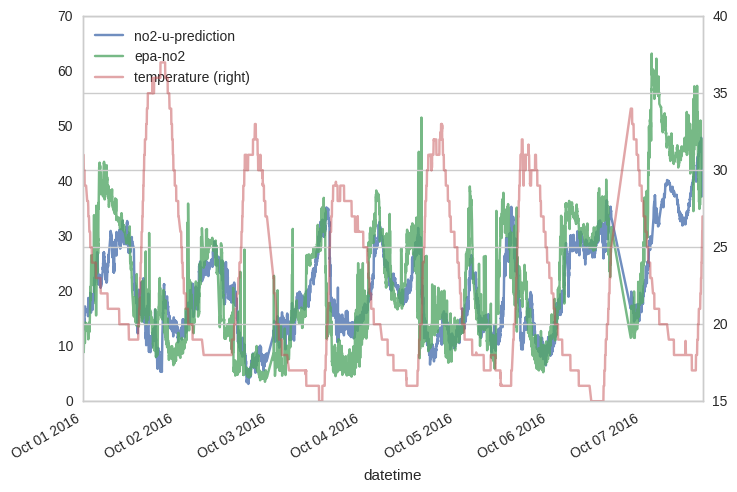

In [18]:
features = ["o3-u", "no2-u", "co-u", "temperature", "humidity", "pressure"]
error, results = benchmark_full(features, "epa-no2")
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
test_data['no2-u-error'] = results[1]
train_data['no2-u-error'] = (results[2].predict(train_data[features]) - train_data[NO2_FEATURES[1]])
test_data['no2-u-prediction'] = results[2].predict(test_data[features])
train_data['no2-u-prediction'] = results[2].predict(train_data[features])
sns.pairplot(test_data, vars=['epa-no2','no2-u-prediction'], diag_kind='kde')
sns.pairplot(test_data, y_vars=['no2-u-error'], x_vars=['temperature', 'humidity', 'pressure'], diag_kind='kde')
plot_prediction('no2-u-prediction', 'epa-no2')
plt.show()

# Making functions for other boards

In [11]:
def get_functions(board_id):
    (X_train, Y_train), (X_test, Y_test) = load_board(board_id)
    data = X_train.join(Y_train)
    co_classifier = Pipeline([('poly', PolynomialFeatures(1)), ('cf', LinearRegression())])
    co_classifier.fit(data[CO_FEATURES[0]], data[CO_FEATURES[1]])
    print("CO")
    print("===========")
    print_function((None, None, co_classifier, CO_FEATURES[0]))
    print()
    
    o3_classifier = Pipeline([('poly', PolynomialFeatures(1)), ('cf', LinearRegression())])
    o3_classifier.fit(data[O3_FEATURES[0]], data[O3_FEATURES[1]])
    print("O3")
    print("===========")
    print_function((None, None, o3_classifier, O3_FEATURES[0]))
    print()
    
    no2_classifier = Pipeline([('poly', PolynomialFeatures(1)), ('cf', Ridge(1))])
    no2_classifier.fit(data[NO2_FEATURES[0]], data[NO2_FEATURES[1]])
    print("NO2")
    print("===========")
    print_function((None, None, no2_classifier, NO2_FEATURES[0]))
    print()

In [12]:
get_functions(4)

CO
f(x) = 0.003230 * co + -0.006324 * temperature + -0.001720 * humidity + -0.009923 * pressure + 10.3995054106

O3
f(x) = 0.326110 * o3 + -0.140444 * co + 1.861654 * temperature + -0.063664 * humidity + 0.229203 * pressure + -273.033684486

NO2
f(x) = -0.261198 * o3 + 0.199896 * no2 + 0.159473 * co + -0.191822 * temperature + -0.490739 * humidity + 0.250096 * pressure + -171.876506828



In [13]:
get_functions(9)

CO
f(x) = 0.000456 * co + -0.041965 * temperature + -0.011068 * humidity + 0.025649 * pressure + -23.6869182368

O3
f(x) = 0.367027 * o3 + -0.144302 * co + 1.865981 * temperature + 0.075312 * humidity + -0.282199 * pressure + 258.10061139

NO2
f(x) = -0.965543 * o3 + 0.903335 * no2 + -0.023427 * co + -1.361629 * temperature + -0.484821 * humidity + 1.604995 * pressure + -1520.1921391

